In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from seaborn import heatmap as hmap
from scipy.stats import ks_2samp as ks2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import AgglomerativeClustering as AC
import warnings
warnings.filterwarnings('ignore')

- numpy: 1.18.1
- pandas: 1.0.0
- matplotlib: 3.1.2
- sklearn: 0.21.3
- seaborn: 0.10.0
- scipy: 1.4.1

# Task 1: Data Cleaning and Visual Inspection

## 0. Getting Started With the Data

In [ ]:
try:
  from google.colab import drive
  import os
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  drive.mount('/content/drive')
  os.chdir("/content/drive/My Drive/Shared/CS 498 Projects/Mini Projects/MP-2")
  os.listdir("/content/drive/My Drive/Shared/CS 498 Projects/Mini Projects/MP-2")
df_ra_he0 = pd.read_csv('Data/RelativeAbundance_HE0.csv', sep=',', index_col='Microbe Name')
df_ra_he1 = pd.read_csv('Data/RelativeAbundance_HE1.csv', sep=',', index_col='Microbe Name')
df_bi_he0 = pd.read_csv('Data/BayesInferenceHE0.csv',     sep=',', index_col='SampleName')
df_bi_he1 = pd.read_csv('Data/BayesInferenceHE1.csv',     sep=',', index_col='SampleName')
df_qa     = pd.read_csv('Data/QualityControl.csv',        sep=',')

df_ra_he0.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,HE0Sample_0,HE0Sample_1,HE0Sample_2,HE0Sample_3,HE0Sample_4,HE0Sample_5,HE0Sample_6,HE0Sample_7,HE0Sample_8,HE0Sample_9,HE0Sample_10,HE0Sample_11,HE0Sample_12,HE0Sample_13,HE0Sample_14,HE0Sample_15,HE0Sample_16,HE0Sample_17,HE0Sample_18,HE0Sample_19,HE0Sample_20,HE0Sample_21,HE0Sample_22,HE0Sample_23,HE0Sample_24,HE0Sample_25,HE0Sample_26,HE0Sample_27,HE0Sample_28,HE0Sample_29,HE0Sample_30,HE0Sample_31,HE0Sample_32,HE0Sample_33,HE0Sample_34,HE0Sample_35,HE0Sample_36,HE0Sample_37,HE0Sample_38,HE0Sample_39,...,HE0Sample_724,HE0Sample_725,HE0Sample_726,HE0Sample_727,HE0Sample_728,HE0Sample_729,HE0Sample_730,HE0Sample_731,HE0Sample_732,HE0Sample_733,HE0Sample_734,HE0Sample_735,HE0Sample_736,HE0Sample_737,HE0Sample_738,HE0Sample_739,HE0Sample_740,HE0Sample_741,HE0Sample_742,HE0Sample_743,HE0Sample_744,HE0Sample_745,HE0Sample_746,HE0Sample_747,HE0Sample_748,HE0Sample_749,HE0Sample_750,HE0Sample_751,HE0Sample_752,HE0Sample_753,HE0Sample_754,HE0Sample_755,HE0Sample_756,HE0Sample_757,HE0Sample_758,HE0Sample_759,HE0Sample_760,HE0Sample_761,HE0Sample_762,HE0Sample_763
Microbe Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Acidobacteria_Acidobacteria_Gp1_Telmatobacter_Telmatobacter,0.004239,0.004345,0.004423,0.004463,0.005372,0.004136,0.004457,0.004049,0.004638,0.004429,0.004629,0.004497,0.003792,0.004527,0.004450,0.004544,0.006296,0.005226,0.003474,0.006629,0.004580,0.005247,0.004085,0.002764,0.003806,0.004061,0.003381,0.004694,0.005550,0.004435,0.005805,0.004323,0.004751,0.003687,0.004216,0.004298,0.003141,0.004798,0.003041,0.005029,...,0.005248,0.004764,0.004330,0.003387,0.003815,0.004794,0.004562,0.004952,0.005893,0.004020,0.006151,0.003475,0.004808,0.004960,0.004998,0.003890,0.003810,0.005867,0.003032,0.005542,0.004216,0.004934,0.005033,0.004251,0.004790,0.004232,0.004888,0.005233,0.004610,0.003900,0.004464,0.004636,0.004046,0.005518,0.005073,0.003527,0.005413,0.003140,0.002998,0.004829
Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3,0.013269,0.012312,0.011611,0.013033,0.013689,0.012752,0.009772,0.012148,0.013743,0.011160,0.011294,0.016603,0.012514,0.009809,0.010198,0.013806,0.010926,0.013761,0.015286,0.011232,0.011174,0.009046,0.010026,0.015377,0.013838,0.011628,0.012677,0.009763,0.011793,0.011886,0.008801,0.010627,0.011513,0.013169,0.013703,0.009312,0.009771,0.009405,0.011212,0.011175,...,0.013469,0.012081,0.012236,0.013369,0.011965,0.010693,0.011659,0.013149,0.014905,0.012061,0.012488,0.011293,0.009615,0.012485,0.010858,0.009446,0.011248,0.012101,0.011238,0.008313,0.014755,0.010573,0.008760,0.012382,0.011975,0.014812,0.013536,0.013082,0.011610,0.012764,0.010603,0.013565,0.012139,0.012875,0.013294,0.014107,0.012694,0.013082,0.008244,0.010401
Actinobacteria_Actinobacteria_Acidimicrobiales_Acidimicrobiaceae,0.003502,0.005251,0.006082,0.003749,0.004332,0.004136,0.004972,0.004930,0.004638,0.003366,0.004629,0.003459,0.005499,0.003773,0.004265,0.005243,0.004815,0.006096,0.006427,0.004051,0.004213,0.004704,0.004642,0.005183,0.002595,0.004430,0.004902,0.004506,0.005203,0.005677,0.005056,0.004143,0.004934,0.003863,0.004216,0.004835,0.004711,0.004990,0.003421,0.003911,...,0.003149,0.005445,0.003765,0.003743,0.004682,0.004056,0.006252,0.003928,0.004159,0.004894,0.005219,0.003475,0.005732,0.005986,0.003792,0.006112,0.005080,0.004950,0.004460,0.004676,0.003864,0.005815,0.005219,0.006283,0.003316,0.004056,0.004512,0.005756,0.003073,0.006382,0.003906,0.002919,0.004782,0.006070,0.003498,0.004408,0.004853,0.004012,0.004310,0.005758
Actinobacteria_Actinobacteria_Actinomycetales_Actinomycetaceae,0.003870,0.005794,0.005345,0.004106,0.002946,0.003963,0.005315,0.003697,0.005326,0.004429,0.004444,0.004151,0.004361,0.004527,0.004265,0.003146,0.003519,0.005922,0.004864,0.003867,0.004580,0.004704,0.005384,0.003283,0.004843,0.005168,0.005240,0.004694,0.003469,0.005322,0.003745,0.004143,0.003655,0.005443,0.006676,0.003761,0.005584,0.003839,0.004941,0.004656,...,0.003323,0.003403,0.003577,0.004278,0.003815,0.005162,0.003211,0.00

### 1. In the context of statistical analysis, why do biologists need multiple samples to identify microbes with significantly altered abundance?

The biologists need multiple samples to identify microbes with significantly altered abundance as increase in
number of samples increases the accuracy of the results and increases the confidence of accuracy of results.


### 2. How many samples were analyzed?

In [ ]:
len(df_ra_he0.columns)

764

### 3. How many microbes were identified?

In [ ]:
len(df_ra_he0.index)

149

## 1. Bayesian Network for Quality Control

### a. Joint Probability Factorization

S = storage Temp, M = collection method, C = contamination, T = lab time before processing, Q = quality
$P(Q,C,S,M,T) = P(Q|C,T).P(C|S,M).P(S).P(M).P(T)$

### b. Parameters Required

$P(Q|C,T) = 4, P(C|S,M) = 4, P(S) = 1, P(M) = 1, P(T) = 1$\
$Total parameters = 4 + 4 + 1 + 1 + 1 = 11$

### c. Constructing Probability Tables

In [ ]:
# P(Storage Temperature)
df_Prob_S = pd.DataFrame({'Probability': [len(df_qa.strtmp[df_qa.strtmp == 'cold'])/len(df_qa.strtmp), 
                          len(df_qa.strtmp[df_qa.strtmp == 'cool'])/len(df_qa.strtmp)]},
                         index=['cold','cool'])
df_Prob_S.index.name = 'Storage Temperature'
df_Prob_S

,Probability
Storage Temperature,
cold,0.8982
cool,0.1018


In [ ]:
# P(Collection Method)
df_Prob_M = pd.DataFrame({'Probability': [len(df_qa.coll[df_qa.coll == 'nurse'])/len(df_qa.coll), 
                          len(df_qa.coll[df_qa.coll == 'patient'])/len(df_qa.coll)]},
                         index=['nurse', 'patient'])
df_Prob_M.index.name = 'Collection Method'
df_Prob_M

,Probability
Collection Method,
nurse,0.8976
patient,0.1024


In [ ]:
# P(Lab time before processing)
df_Prob_T = pd.DataFrame({'Probability': [len(df_qa.labtime[df_qa.labtime == 'short'])/len(df_qa.labtime), 
                          len(df_qa.labtime[df_qa.labtime == 'long'])/len(df_qa.labtime)]},
                         index=['short', 'long'])
df_Prob_T.index.name = 'Lab Time'
df_Prob_T

,Probability
Lab Time,
short,0.7956
long,0.2044


In [ ]:
# P(Quality|Contamination, Lab Time)
low, high      = (df_qa.cont == 'low'),      (df_qa.cont == 'high')
short, long    = (df_qa.labtime == 'short'), (df_qa.labtime == 'long')
good, bad      = (df_qa.qual == 'good'),     (df_qa.qual == 'bad')
cold, cool     = (df_qa.strtmp == 'cold'),   (df_qa.strtmp == 'cool')
nurse, patient = (df_qa.coll == 'nurse'),    (df_qa.coll == 'patient')

iterables = [['low','high'], ['short','long']]

df_Prob_Q_g_CT = pd.DataFrame({'Probability(Q=good)': [len(df_qa.qual[good & low & short])/len(df_qa.qual[low & short]), 
                               len(df_qa.qual[good & low & long])/len(df_qa.qual[low & long]),
                               len(df_qa.qual[good & high & short])/len(df_qa.qual[high & short]), 
                               len(df_qa.qual[good & high & long])/len(df_qa.qual[high & long])],
                               'Probability(Q=bad)': [len(df_qa.qual[bad & low & short])/len(df_qa.qual[low & short]), 
                               len(df_qa.qual[bad & low & long])/len(df_qa.qual[low & long]),
                               len(df_qa.qual[bad & high & short])/len(df_qa.qual[high & short]), 
                               len(df_qa.qual[bad & high & long])/len(df_qa.qual[high & long])]},
                              index = pd.MultiIndex.from_product(iterables, 
                                                                 names=['Contamination', 'Lab Time']))
df_Prob_Q_g_CT

Probability(Q=good)  Probability(Q=bad)
Contamination Lab Time                                         
low           short                0.957093            0.042907
              long                 0.919003            0.080997
high          short                0.935743            0.064257
              long                 0.033898            0.966102

In [ ]:
# P(Contamination|Storage Temp, Collection Method),
iterables = [['cold','cool'], ['nurse','patient']]


df_Prob_C_g_SM = pd.DataFrame({'Probability(C=low)': [len(df_qa.cont[low & cold & nurse])/len(df_qa.cont[cold & nurse]), 
                               len(df_qa.cont[low & cold & patient])/len(df_qa.cont[cold & patient]),
                               len(df_qa.cont[low & cool & nurse])/len(df_qa.cont[cool & nurse]), 
                               len(df_qa.cont[low & cool & patient])/len(df_qa.cont[cool & patient])],
                               'Probability(C=high)': [len(df_qa.cont[high & cold & nurse])/len(df_qa.cont[cold & nurse]), 
                               len(df_qa.cont[high & cold & patient])/len(df_qa.cont[cold & patient]),
                               len(df_qa.cont[high & cool & nurse])/len(df_qa.cont[cool & nurse]), 
                               len(df_qa.cont[high & cool & patient])/len(df_qa.cont[cool & patient])]}, 
                              index = pd.MultiIndex.from_product(iterables, 
                                                                 names=['Storage Temperature', 'Collection Methods']))
df_Prob_C_g_SM

Probability(C=low)  Probability(C=high)
Storage Temperature Collection Methods                                         
cold                nurse                         0.956017             0.043983
                    patient                       0.923423             0.076577
cool                nurse                         0.911565             0.088435
                    patient                       0.161765             0.838235

### d. Final Probability Tables

$P(Q|S,M,T) = \frac{\sum_c P(Q,C,S,M,T)}{P(S,M,T}$

$P(Q|S,M,T) = \frac{\sum_c (P(Q|T,C).P(C|S,M).P(S).P(M).P(T))}{P(S).P(M).P(T)}$

$P(Q|S,M,T) = P(Q|T,C=low)\times P(C=low|S,M) + P(Q|T,C=high)\times P(C=high|S,M)$

In [ ]:
iterables = [['cold','cool'],['nurse','patient'], ['short','long']]
SMT_Combinations = pd.MultiIndex.from_product(iterables, 
                                   names=['Storage Temperature', 'Collection Methods', 'Lab Time'])
Quality = ['good', 'bad']

Prob_Q_good_g_SMT = []
Prob_Q_bad_g_SMT = []
for S,M,T in SMT_Combinations:
    Prob_Q_good = df_Prob_Q_g_CT.loc[('low', T),['Probability(Q=good)']].values* \
    df_Prob_C_g_SM.loc[(S, M),['Probability(C=low)']].values + \
    df_Prob_Q_g_CT.loc[('high', T),['Probability(Q=good)']].values* \
    df_Prob_C_g_SM.loc[(S, M),['Probability(C=high)']].values
    Prob_Q_good_g_SMT.append(Prob_Q_good[0])
    Prob_Q_bad_g_SMT.append(1-Prob_Q_good[0])

df_Prob_Q_g_SMT = pd.DataFrame({'Probability(Q=good)': Prob_Q_good_g_SMT,'Probability(Q=bad)': Prob_Q_bad_g_SMT},
                              index = SMT_Combinations)
df_Prob_Q_g_SMT

Probability(Q=good)  Probability(Q=bad)
Storage Temperature Collection Methods Lab Time                                         
cold                nurse              short                0.956154            0.043846
                                       long                 0.880073            0.119927
                    patient            short                0.955458            0.044542
                                       long                 0.851225            0.148775
cool                nurse              short                0.955205            0.044795
                                       long                 0.840729            0.159271
                    patient            short                0.939197            0.060803
                                       long                 0.177077            0.822923

### e. Cleaning the dataset

In [ ]:
index_df_bi_he0_BadQ = df_bi_he0[(df_bi_he0['strtmp'] == 'cool') & 
                                 (df_bi_he0['coll'] == 'patient') & 
                                 (df_bi_he0['labtime'] == 'long') ].index

df_bi_he0_GoodQ = df_bi_he0.drop(index_df_bi_he0_BadQ)
print('Total Rows of BayesInferenceHE0 Before Dropping: %s, After Dropping: %s' % 
      (len(df_bi_he0),len(df_bi_he0_GoodQ)))

Total Rows of BayesInferenceHE0 Before Dropping: 764, After Dropping: 699


In [ ]:
index_df_bi_he1_BadQ = df_bi_he1[(df_bi_he1['strtmp'] == 'cool') & 
                                 (df_bi_he1['coll'] == 'patient') & 
                                 (df_bi_he1['labtime'] == 'long') ].index

df_bi_he1_GoodQ = df_bi_he1.drop(index_df_bi_he1_BadQ)
print('Total Rows of BayesInferenceHE1 Before Dropping: %s, After Dropping: %s' % 
      (len(df_bi_he1),len(df_bi_he1_GoodQ)))

Total Rows of BayesInferenceHE1 Before Dropping: 764, After Dropping: 699


In [ ]:
# bad quality samples for BayesInferenceHE0
df_bi_he0.loc[index_df_bi_he0_BadQ]

,strtmp,coll,labtime
SampleName,,,
HE0Sample_699,cool,patient,long
HE0Sample_700,cool,patient,long
HE0Sample_701,cool,patient,long
HE0Sample_702,cool,patient,long
HE0Sample_703,cool,patient,long
...,...,...,...
HE0Sample_759,cool,patient,long
HE0Sample_760,cool,patient,long
HE0Sample_761,cool,patient,long


In [ ]:
# bad quality samples for BayesInferenceHE1
df_bi_he1.loc[index_df_bi_he1_BadQ]

,strtmp,coll,labtime
SampleName,,,
HE1Sample_699,cool,patient,long
HE1Sample_700,cool,patient,long
HE1Sample_701,cool,patient,long
HE1Sample_702,cool,patient,long
HE1Sample_703,cool,patient,long
...,...,...,...
HE1Sample_759,cool,patient,long
HE1Sample_760,cool,patient,long
HE1Sample_761,cool,patient,long


## 2. Data Standardization

### 1. Verify Relative Abundance

In [ ]:
column_list = (list(df_ra_he0.columns))
column_list.remove(column_list[0])
not_one = []
for i in column_list:
    if abs(float(df_ra_he0[i].sum())-float(1))<=(10^-10):
        not_one.append(i)
print("Total no.of columns that dont equal one are",len(not_one))

Total no.of columns that dont equal one are 0


In [ ]:
column_list = (list(df_ra_he1.columns))
column_list.remove(column_list[0])
not_one = []
for i in column_list:
    if abs(float(df_ra_he1[i].sum())-float(1))<=(10^-10):
        not_one.append(i)
print("Total no.of columns that dont equal one are",len(not_one))

Total no.of columns that dont equal one are 0


### 2. Discussion on Relative Abundance Data

The benefits of relative abundance owuld be that it helps to easily realize which microbe is in highest and lowest quantity relative to others. But the backdraw is we can't know the actual values of the samples as we only have relative abundance. We may lose some information in rare cases, like in presence of extreme outliers.

## 3. Visual Inspection

In [ ]:
df_ra_he0.shape

(149, 764)

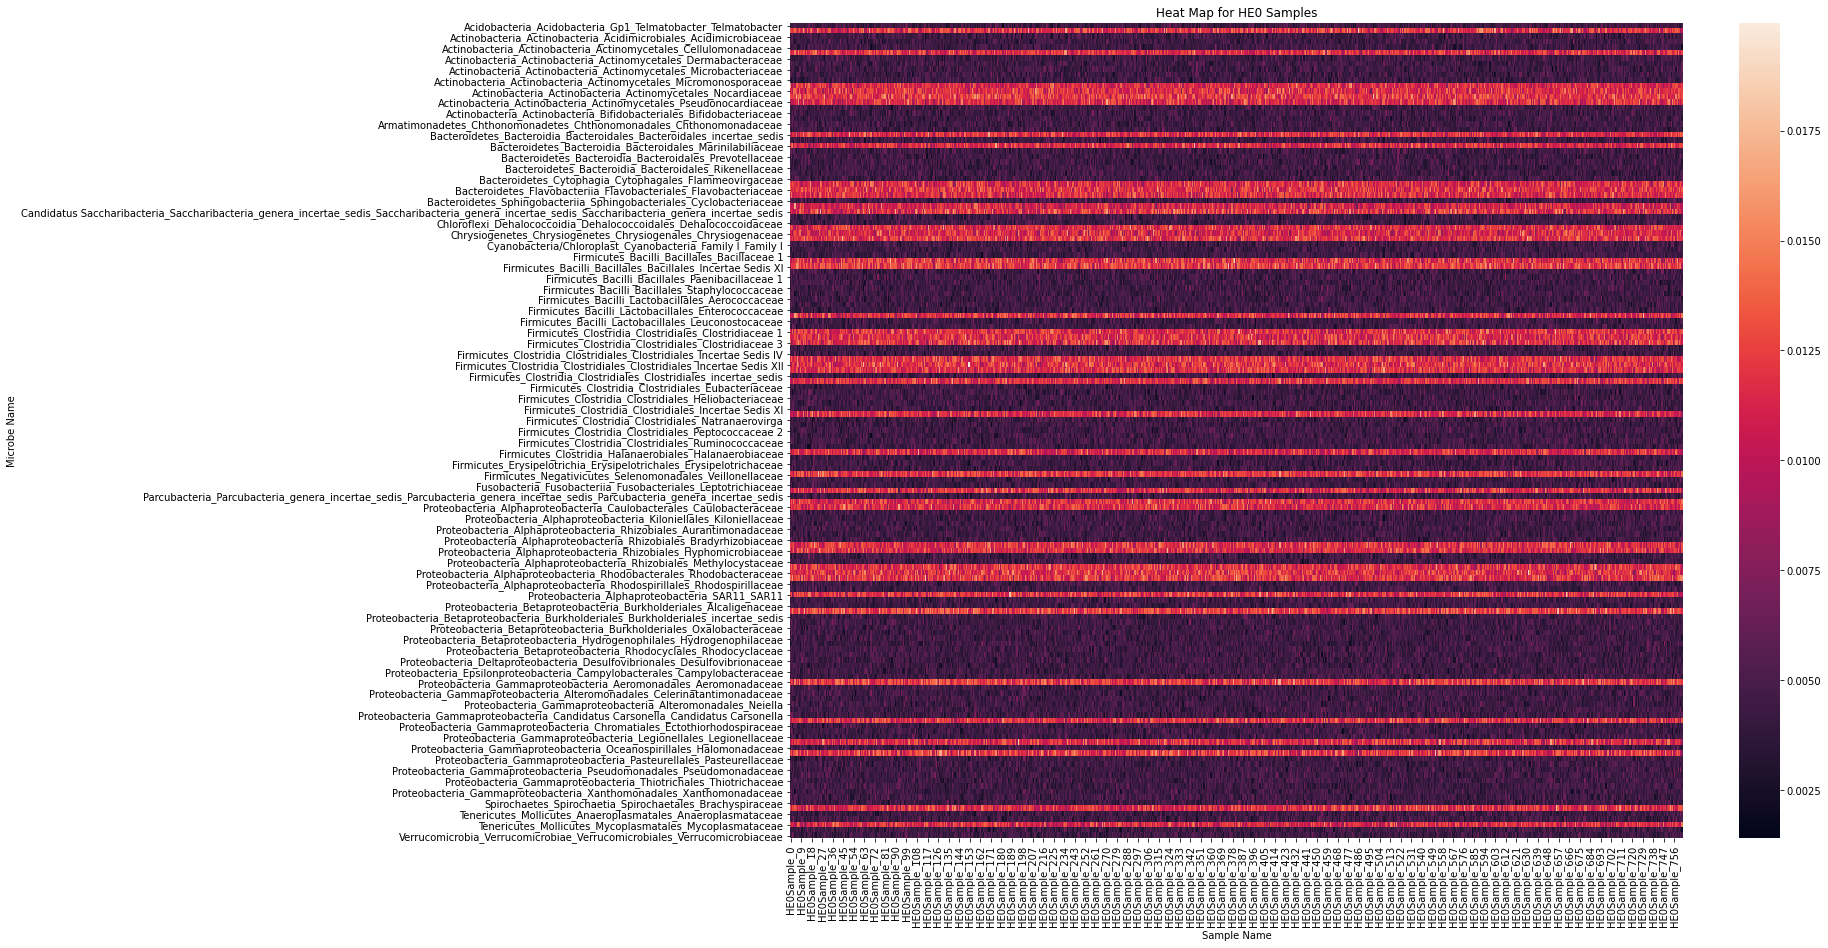

In [ ]:
plt.figure(figsize=(20,15))
plot_ra_he0 = hmap(df_ra_he0);
figure = plot_ra_he0.get_figure()
plt.xlabel("Sample Name")
plt.title("Heat Map for HE0 Samples")
figure.savefig('df_ra_he0.png', bbox_inches= 'tight')

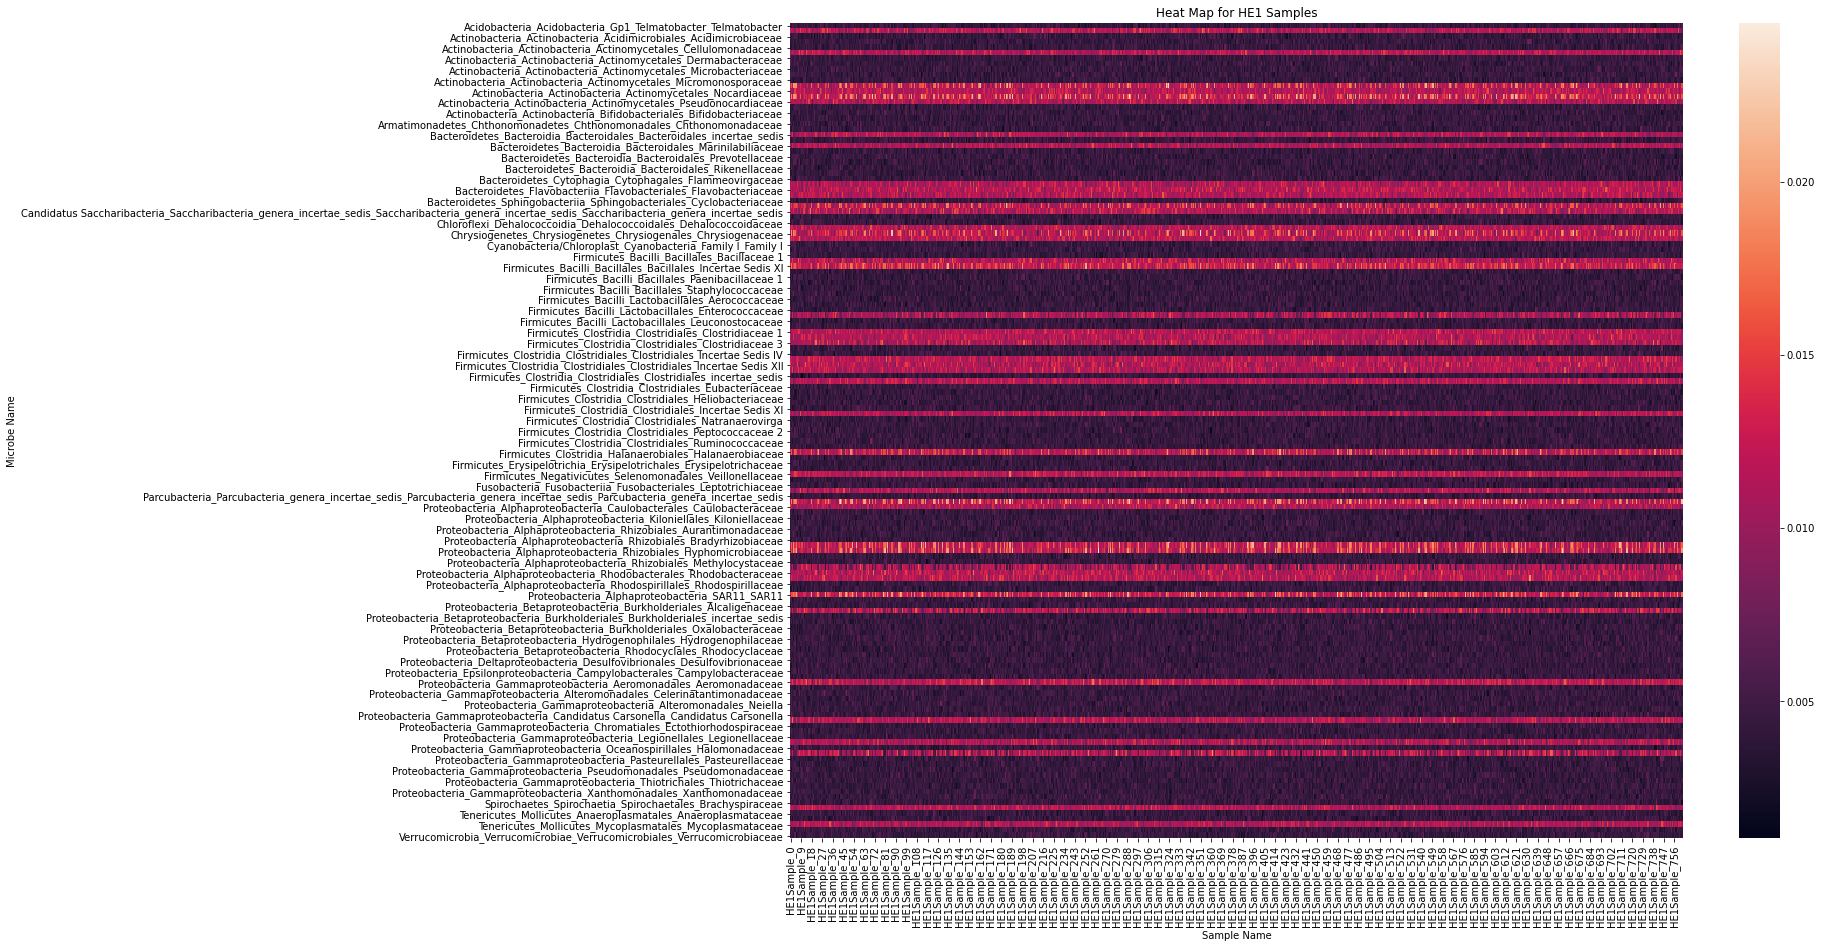

In [ ]:
plt.figure(figsize=(20,15))
plot_ra_he1 = hmap(df_ra_he1);
figure = plot_ra_he0.get_figure()
plt.xlabel("Sample Name")
plt.title("Heat Map for HE1 Samples")
figure.savefig('df_ra_he1.png', bbox_inches= 'tight')

# Task 2: Statistical Analysis

## 1. Kolmogorov-Smirnov (KS) Test

### a. p-value for Two-Sample KS Test

In [ ]:
pValue_Microbes = []
for indexName in df_ra_he1.index:
    pValue = ks2(df_ra_he0.loc[indexName], df_ra_he1.loc[indexName]).pvalue
    pValue_Microbes.append(pValue)
df_pValue_Microbes = pd.DataFrame({'Microbe Name': df_ra_he1.index,
                                  'P-Value': pValue_Microbes}).set_index('Microbe Name')
df_pValue_Microbes.head()

,P-Value
Microbe Name,
Acidobacteria_Acidobacteria_Gp1_Telmatobacter_Telmatobacter,0.177747
Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3,0.002248
Actinobacteria_Actinobacteria_Acidimicrobiales_Acidimicrobiaceae,0.086320
Actinobacteria_Actinobacteria_Actinomycetales_Actinomycetaceae,0.909664
Actinobacteria_Actinobacteria_Actinomycetales_Cellulomonadaceae,0.726977


### b. Null Hypothesis of the KS Test in our Context

Considering the microbe- Acidobacteria_Acidobacteria_Gp1_Telmatobacter_Telmatobacter for the KS test. 
Null Hypothesis-
The distributions of Acidobacteria_Acidobacteria_Gp1_Telmatobacter_Telmatobacter in HE0 and HE1 samples are same.


### c. Number of Genes with Significantly Altered Expression at Various Alpha Values

In [ ]:
alpha = [0.1, 0.05, 0.01, 0.005, 0.001]
altered_Microbes = []
for a in alpha:
    altered_Microbes.append(len(df_pValue_Microbes[df_pValue_Microbes['P-Value']<=a]))
df_altered_Microbes = pd.DataFrame({'Alpha': alpha,
                                  'Altered Microbes': altered_Microbes}).set_index('Alpha')
df_altered_Microbes

,Altered Microbes
Alpha,
0.100,48
0.050,36
0.010,27
0.005,24
0.001,20


## 2. Multiple Testing

### a. P-value

when p-value is less than 0.05, it means the samples do not come from same distribution, otherwise, they come from same distribution.

### b. P-value Distribution

When the null hypothesis is true and the underlying random variable is continuous, then the probability distribution of the p-value is uniform on the interval [0,1]. However, if the alternative hypothesis is true, the distribution is dependent on sample size and the true value of the parameter being studied.

Source: https://en.wikipedia.org/wiki/P-value

### c. Expected Number of Significant p-values

In [ ]:
df_altered_Microbes['Expected Altered Microbes'] = [149*a for a in alpha]
df_altered_Microbes

,Altered Microbes,Expected Altered Microbes
Alpha,,
0.100,48,14.900
0.050,36,7.450
0.010,27,1.490
0.005,24,0.745
0.001,20,0.149


### d. Q-Q plot of p-values

#### i. 

In [ ]:
np.random.seed(1000)
expected_pValue = np.random.uniform(0,1,149)

#### ii. 

In [ ]:
log_exp_pValue = -np.log10(expected_pValue)
log_obs_pValue = -np.log10(pValue_Microbes)

#### iii. 

In [ ]:
sort_exp_pValue = np.sort(log_exp_pValue)
sort_obs_pValue = np.sort(log_obs_pValue)

#### iv. 

(-2.0, 10.0)

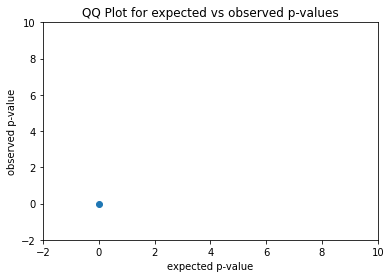

In [ ]:
plt.scatter(sort_exp_pValue[0],sort_obs_pValue[0]);
plt.title("QQ Plot for expected vs observed p-values")
plt.xlabel("expected p-value")
plt.ylabel("observed p-value")
plt.xlim([-2,10])
plt.ylim([-2,10])

#### v. 

(0.0, 10.0)

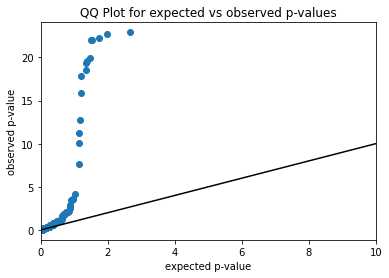

In [ ]:
plt.scatter(sort_exp_pValue,sort_obs_pValue);
x = np.linspace(0,10,1000)
plt.plot(x, x, color='black')
plt.title("QQ Plot for expected vs observed p-values")
plt.xlabel("expected p-value")
plt.ylabel("observed p-value")
plt.xlim([0,10])

#### vi. 

### e. Follow-up Questions

#### i. 

Taking –log10() of the p-values helps in normalizing the p –values, the scaled p-values distributions visualizations are clearer.

#### ii. 

Since the values plotted do not fall over the x=y line, it can be concluded that the expected p-value and observed p-value do not belong to the same distribution.


# Task 3: Dimensionality Reduction and Clustering

## 1. PCA

### a. Performing PCA

In [ ]:
# Data frame for relative abundance of microbe of Good sample
df_ra_he0_GoodQ = df_ra_he0.T.drop(index_df_bi_he0_BadQ)
df_ra_he1_GoodQ = df_ra_he1.T.drop(index_df_bi_he1_BadQ)

# Fit PCA
PCA_he0 = PCA(svd_solver='full')
PCA_he1 = PCA(svd_solver='full')
pca_fit_he0 = PCA_he0.fit_transform(df_ra_he0_GoodQ)
pca_fit_he1 = PCA_he1.fit_transform(df_ra_he1_GoodQ)

# Dataframe for PCA components of He0 and He1
df_pca_he0 = pd.DataFrame(data = pca_fit_he0,
                          columns = ['PCA-'+str(i+1) \
                                     for i in range(len(pca_fit_he0[0]))],
                          index = df_ra_he0_GoodQ.index)
df_pca_he1 = pd.DataFrame(data = pca_fit_he1,
                          columns = ['PCA-'+str(i+1) \
                                     for i in range(len(pca_fit_he1[0]))],
                          index = df_ra_he1_GoodQ.index)


### b. Ordering Components

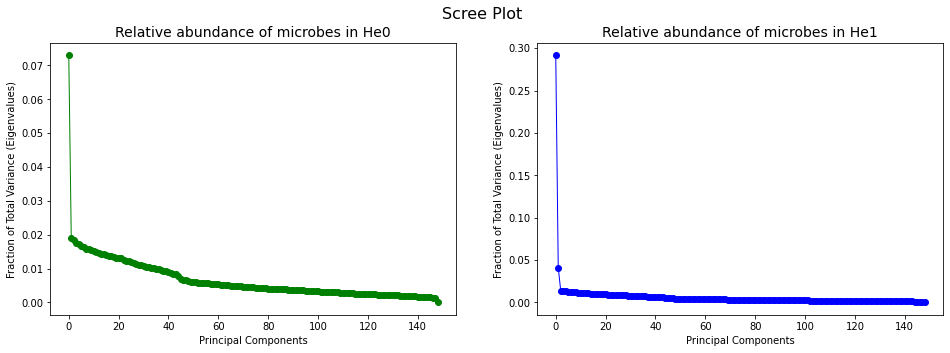

In [ ]:
# Variance explained by PCAs
variance_he0 = PCA_he0.explained_variance_ratio_
variance_he1 = PCA_he1.explained_variance_ratio_

# Screen Plots ploting
fig = plt.figure(figsize=(16,5));
plt.suptitle('Scree Plot', fontsize=16);

plt.subplot(121)
plt.plot(variance_he0, 'go-', linewidth=1);
plt.title('Relative abundance of microbes in He0', fontsize=14);
plt.xlabel('Principal Components');
plt.ylabel('Fraction of Total Variance (Eigenvalues)');

plt.subplot(122)
plt.plot(variance_he1, 'bo-', linewidth=1);
plt.title('Relative abundance of microbes in He1', fontsize=14);
plt.xlabel('Principal Components');
plt.ylabel('Fraction of Total Variance (Eigenvalues)');

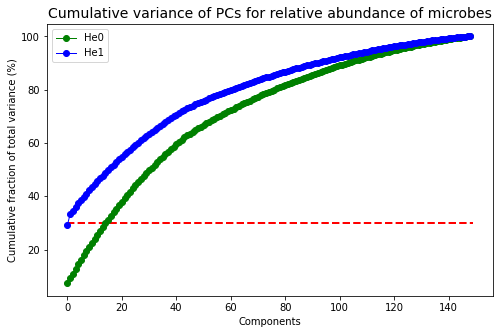

In [ ]:
# Cumulative PCAs variance plots
fig = plt.figure(figsize=(8,5));

plt.plot(np.cumsum(variance_he0)*100, 'go-', linewidth=1, label='He0');
plt.plot(np.cumsum(variance_he1)*100, 'bo-', linewidth=1, label='He1');
plt.hlines(y=30,xmin=0, xmax=149, linewidth=2, color='r',linestyles='dashed')
plt.title('Cumulative variance of PCs for relative abundance of microbes',
          fontsize=14);
plt.xlabel('Components');
plt.ylabel('Cumulative fraction of total variance (%)');
plt.legend();

In [ ]:
# Number of PCAs to explain 30% of Variance
PCs_he0_30 = len(np.cumsum(variance_he0)[np.cumsum(variance_he0)<0.3])+1
PCs_he1_30 = len(np.cumsum(variance_he1)[np.cumsum(variance_he1)<0.3])+1

print('Number of principal components to explain 30% of variance in He0: ', 
      PCs_he0_30)
print('Number of principal components to explain 30% of variance in He1: ', 
      PCs_he1_30)

Number of principal components to explain 30% of variance in He0:  16
Number of principal components to explain 30% of variance in He1:  2


The Prinicipal Components needed to explain 30% of the total variance for He0 and He1 are 15 and 1, respectively.

### c. Scatter Plot of Microbe Abundance

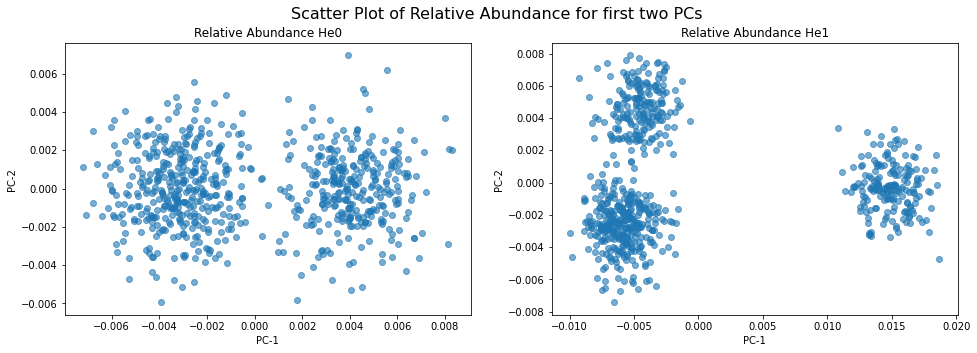

In [ ]:
# Scatter plots with first two PCAs
fig = plt.figure(figsize=(16,5));
plt.suptitle('Scatter Plot of Relative Abundance for first two PCs', 
             fontsize=16);

plt.subplot(121)
plt.scatter(df_pca_he0.iloc[:,0],df_pca_he0.iloc[:,1], alpha=0.6);
plt.xlabel("PC-1");
plt.ylabel("PC-2");
plt.title("Relative Abundance He0");

plt.subplot(122)
plt.scatter(df_pca_he1.iloc[:,0],df_pca_he1.iloc[:,1], alpha=0.6);
plt.xlabel("PC-1");
plt.ylabel("PC-2");
plt.title("Relative Abundance He1");

**Summary:** There are two possible clusters in He0 samples, whereas, there are three possible clusters in He1 samples. Both the clusters in He0 have shared data points; however, in the He1, one cluster is clearly separated from the other two clusters. The other two clusters in He1 also have shared data points.

## 2. t-SNE

### a. Performing t-SNE

In [ ]:
# t-SNE with Random State = 42, 62, 82
df_tsne = []
for i in [42,62,82]:
  tsne_he0 = TSNE(random_state=i).fit_transform(df_ra_he0_GoodQ)
  tsne_he1 = TSNE(random_state=i).fit_transform(df_ra_he1_GoodQ)

  df_tsne_he0 = pd.DataFrame(data = tsne_he0,
                            columns = ['TSNE-1', 'TSNE-2'],
                            index = df_ra_he0_GoodQ.index)
  df_tsne_he1 = pd.DataFrame(data = tsne_he1,
                            columns = ['TSNE-1', 'TSNE-2'],
                            index = df_ra_he1_GoodQ.index)
  df_tsne.append(df_tsne_he0)
  df_tsne.append(df_tsne_he1)

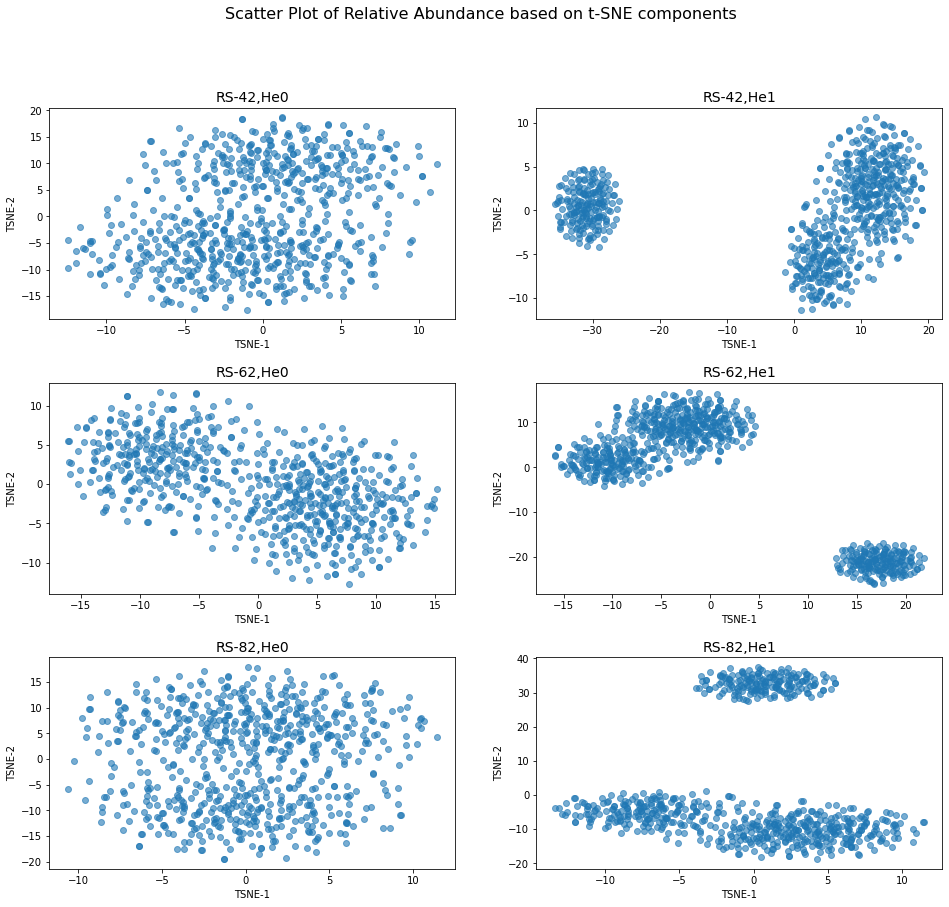

In [ ]:
# Cluster analysis with Scatter plots for t-SNE
fig = plt.figure(figsize=(16,14));
plt.suptitle('Scatter Plot of Relative Abundance based on t-SNE components',
             fontsize=16);

title = ['RS-42,He0','RS-42,He1',
         'RS-62,He0','RS-62,He1',
         'RS-82,He0','RS-82,He1']

for i,df in enumerate(df_tsne):
  plt.subplot(3,2,i+1)
  plt.scatter(df_tsne[i]["TSNE-1"],df_tsne[i]["TSNE-2"], alpha=0.6);
  plt.xlabel("TSNE-1");
  plt.ylabel("TSNE-2");
  plt.title(title[i], fontsize=14);

plt.subplots_adjust(hspace=0.3)

From all the random states used for t-SNE clustering, one thing is clear that He0 can have two possible clusters, whereas, for He1, there can be three clusters possible. Among the different random states, the only changes are spotted in the components values, otherwise change in random state does not have any significant impact on the number of spotted clusters.

### b. Comparing with PCA

**Similarity:** Both t-SNE and PCA came up with two and three possible clusters for He0 and He1, respectively. 

**Difference:** PCA seems better in capturing the variance in the data and differentiating between the clusters than t-SNE. Since the shared data points among the different clusters are more in t-SNE than PCA.

## 3. Clustering

### a. K-Means

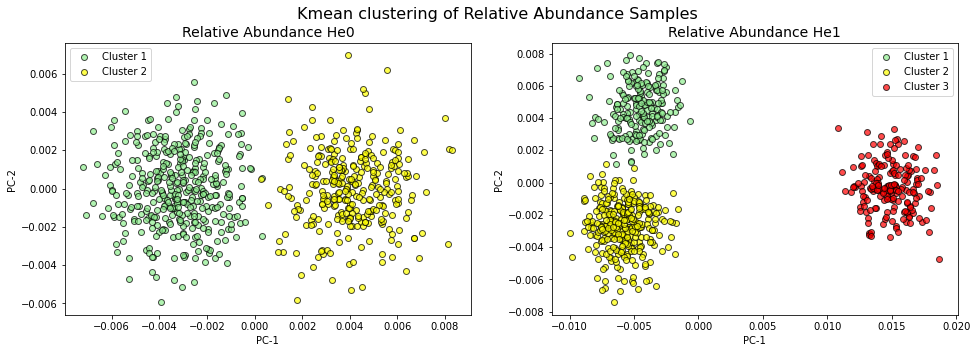

In [ ]:
# k-means fitting
kmeans_he0= KMeans(n_clusters=2, random_state=0).fit_predict(df_pca_he0)
kmeans_he1= KMeans(n_clusters=3, random_state=0).fit_predict(df_pca_he1)

# Cluster Analysis with k-means clustering method
fig = plt.figure(figsize=(16,5));
plt.suptitle('Kmean clustering of Relative Abundance Samples', fontsize=16);
color = ['lightgreen', 'yellow', 'red']
cluster = ['Cluster 1', 'Cluster 2', 'Cluster 3']
plt.subplot(121)
for i in range(2):
  plt.scatter(df_pca_he0.iloc[np.where(kmeans_he0==i)[0],0], 
              df_pca_he0.iloc[np.where(kmeans_he0==i)[0],1],
              c=color[i], 
              marker='o', edgecolor='black', alpha=0.7, label=cluster[i])
plt.legend(scatterpoints=1)
plt.xlabel("PC-1");
plt.ylabel("PC-2");
plt.title("Relative Abundance He0", fontsize=14);

plt.subplot(122)
for i in range(3):
  plt.scatter(df_pca_he1.iloc[np.where(kmeans_he1==i)[0],0], 
              df_pca_he1.iloc[np.where(kmeans_he1==i)[0],1],
              c=color[i], 
              marker='o', edgecolor='black', alpha=0.7, label=cluster[i])
plt.legend(scatterpoints=1)
plt.xlabel("PC-1");
plt.ylabel("PC-2");
plt.title("Relative Abundance He1", fontsize=14);

### b. GMM

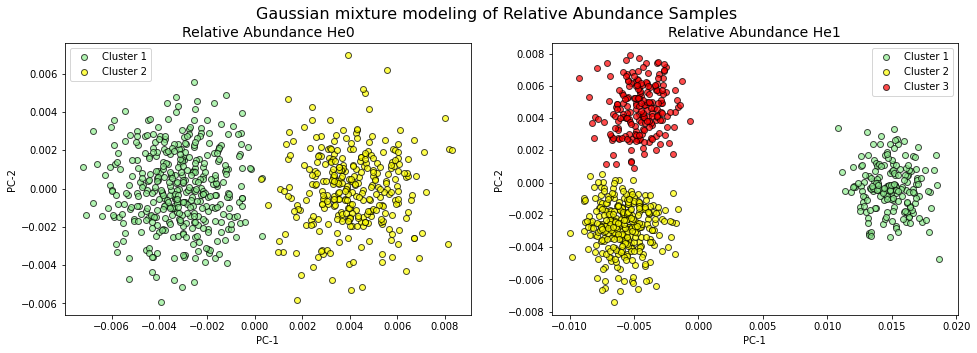

In [ ]:
# GMM fitting
gmm_he0= GMM(n_components=2, random_state=0).fit_predict(df_pca_he0)
gmm_he1= GMM(n_components=3, random_state=0).fit_predict(df_pca_he1)

# Cluster Analysis with GMM clustering method
fig = plt.figure(figsize=(16,5));
plt.suptitle('Gaussian mixture modeling of Relative Abundance Samples', 
             fontsize=16);

plt.subplot(121)
for i in range(2):
  plt.scatter(df_pca_he0.iloc[np.where(gmm_he0==i)[0],0], 
              df_pca_he0.iloc[np.where(gmm_he0==i)[0],1],
              c=color[i], 
              marker='o', edgecolor='black', alpha=0.7, label=cluster[i])
plt.legend(scatterpoints=1)
plt.xlabel("PC-1");
plt.ylabel("PC-2");
plt.title("Relative Abundance He0", fontsize=14);

plt.subplot(122)
for i in range(3):
  plt.scatter(df_pca_he1.iloc[np.where(gmm_he1==i)[0],0], 
              df_pca_he1.iloc[np.where(gmm_he1==i)[0],1],
              c=color[i], 
              marker='o', edgecolor='black', alpha=0.7, label=cluster[i])
plt.legend(scatterpoints=1)
plt.xlabel("PC-1");
plt.ylabel("PC-2");
plt.title("Relative Abundance He1", fontsize=14);

### c. Single and Complete Linkage Hierarchical

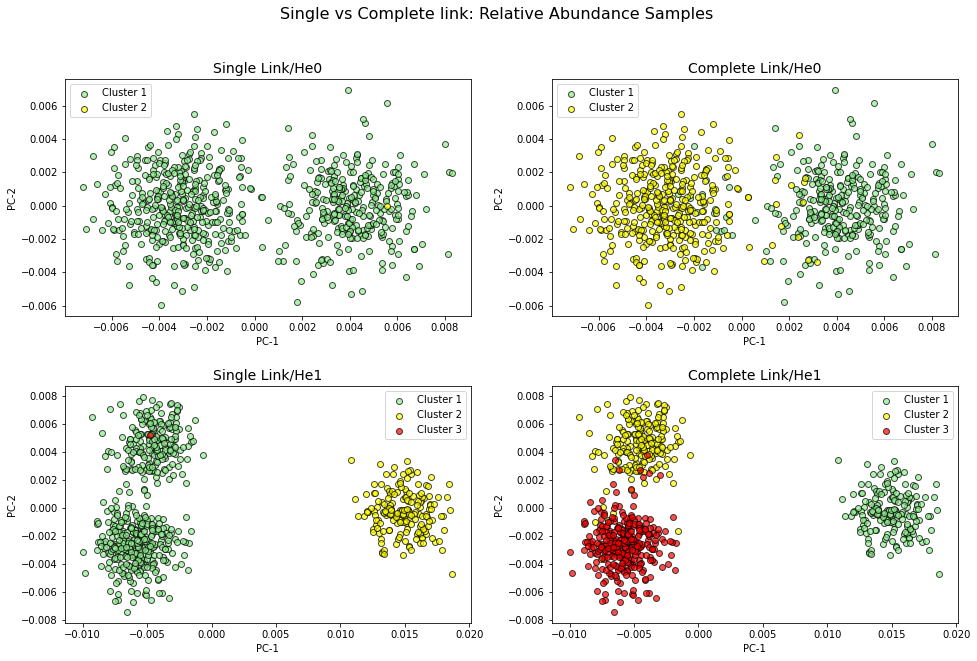

In [ ]:
# Cluster Analysis with Single and complete linkage clustering method
fig = plt.figure(figsize=(16,10));
plt.suptitle('Single vs Complete link: Relative Abundance Samples', 
             fontsize=16);

# Single Linkage
ac_single_he0=AC(n_clusters=2,linkage='single').fit_predict(df_pca_he0) 
ac_single_he1=AC(n_clusters=3,linkage='single').fit_predict(df_pca_he1)
# Complete Linkage
ac_complete_he0=AC(n_clusters=2,linkage='complete').fit_predict(df_pca_he0)
ac_complete_he1=AC(n_clusters=3,linkage='complete').fit_predict(df_pca_he1) 

for i in range(2):
  plt.subplot(221)
  plt.scatter(df_pca_he0.iloc[np.where(ac_single_he0==i)[0],0], 
              df_pca_he0.iloc[np.where(ac_single_he0==i)[0],1],
              c=color[i], 
              marker='o', edgecolor='black', alpha=0.7, label=cluster[i]);
  plt.legend(scatterpoints=1);
  plt.xlabel("PC-1");
  plt.ylabel("PC-2");
  plt.title('Single Link/He0', fontsize=14);

  plt.subplot(222)
  plt.scatter(df_pca_he0.iloc[np.where(ac_complete_he0==i)[0],0], 
              df_pca_he0.iloc[np.where(ac_complete_he0==i)[0],1],
              c=color[i], 
              marker='o', edgecolor='black', alpha=0.7, label=cluster[i]);
  plt.legend(scatterpoints=1);
  plt.xlabel("PC-1");
  plt.ylabel("PC-2");
  plt.title('Complete Link/He0', fontsize=14);

for i in range(3):
  plt.subplot(223)
  plt.scatter(df_pca_he1.iloc[np.where(ac_single_he1==i)[0],0], 
              df_pca_he1.iloc[np.where(ac_single_he1==i)[0],1],
              c=color[i], 
              marker='o', edgecolor='black', alpha=0.7, label=cluster[i]);
  plt.legend(scatterpoints=1);
  plt.xlabel("PC-1");
  plt.ylabel("PC-2");
  plt.title('Single Link/He1', fontsize=14);

  plt.subplot(224)
  plt.scatter(df_pca_he1.iloc[np.where(ac_complete_he1==i)[0],0], 
              df_pca_he1.iloc[np.where(ac_complete_he1==i)[0],1],
              c=color[i], 
              marker='o', edgecolor='black', alpha=0.7, label=cluster[i]);
  plt.legend(scatterpoints=1);
  plt.xlabel("PC-1");
  plt.ylabel("PC-2");
  plt.title('Complete Link/He1', fontsize=14);

plt.subplots_adjust(hspace=0.3);

### d. Single vs Complete Link Hierarchical Clustering

**Single vs complete linkage:** From the above plots, single linkage completely missed the clusters which are really close and have some shared data points, like in He0, it was a complete failure (both the clusters in green), whereas, in He1, it did differentiate between the data points (yellow and green) which are quite far from each other but failed to differentiate between close clusters (green: two cluster possible). However, complete linkage seems better than single linkage since it did differentiate all the clusters possible for both He0 and He1. Still, there are a lot of data points which complete linkage messed up by allocating in different cluster where they do not belong.

The possible reason of this could be that the single linkage algorithm is based on minimum distance, hence it could not differentiate the points which were close. However, the complete linkage algorithm is based on maximum distance, it was able to differentiate between the close clusters.

### e. Comparing Clustering Techniques

Single and complete linkage definitely are not better than k-means and GMM clustering, since single link completely missed the closely spaced clusters and complete link allocated a lot of data points into different cluster where it did not belong. K-means and GMM were quite close. For He0, both the clustering methods assigned all the points exactly in the same. For He1, a few points between cluster 3 and 2 in GMM, and between cluster 1 and 2 in k-means are differently assigned. Cluster1 in kmeans (Cluster3 in GMM) have a lot outliers than Cluster2 (in both). Cluster2 (in both) have more concentrated points than Cluster1 in kmeans (Cluster3 in GMM) which means the shared point between both the clusters should be in Cluster1 in kmeans (Cluster3 in GMM) instead of Cluster2 (in both). Since GMM clustering did quite well in identifying those points, it is selected for cluster analysis. 

### f. What do Clusters Represent

Based on context, the clusters represent the subpopulations in He0 and He1 respectively. The factors that effect the clustering pattern is the relative abundance of microbes. The clusters are possibily generated by combining samples with similar relative abundance of microbes.

### g. Deciding on Number of Clusters



*   We only consider first two principal components in both He0 and He1. For He1, since first two components explained 30% of dataset. However, for He0, the first two principal components explained only 9% of dataset. Therefore, we are more confident on clustering pattern of He1 than He0. Here, we might be inaccurate.
*   We could have first analyzed with domain expertise that which microbes are similar in nature. With than we could have removed (average out) them in the beginning before applying PCA. This could have increased the variance explained by first two components; hence, better clustering.
*   Since we are identifying the cluster using visual inspection, we might be inacurate in it. There could be very small difference in microbes relative abundance. We need better approach to find the clusters instead of using visual inspection.





# Task 4: Interpreting Results

## 1. Identify Microbes with Altered Abundance Levels

### a. Determine if each HE1 Subpopulation shows altered abundance levels

We are calculating mean of all samples in all the clusters of both HE0 and HE1 populations to get the mean value of each microbe in each cluster.Then we are calculating the percentage difference between all combinations of the clusters to find the significantly altered microbes.

In [ ]:
#DataFrames for each cluster of HE0 and HE1
df_ra_he0_c1 = df_ra_he0_GoodQ.iloc[np.where(gmm_he0==0)[0],:]
df_ra_he0_c2 = df_ra_he0_GoodQ.iloc[np.where(gmm_he0==1)[0],:]

df_ra_he1_c1 = df_ra_he1_GoodQ.iloc[np.where(gmm_he1==0)[0],:]
df_ra_he1_c2 = df_ra_he1_GoodQ.iloc[np.where(gmm_he1==1)[0],:]
df_ra_he1_c3 = df_ra_he1_GoodQ.iloc[np.where(gmm_he1==2)[0],:]

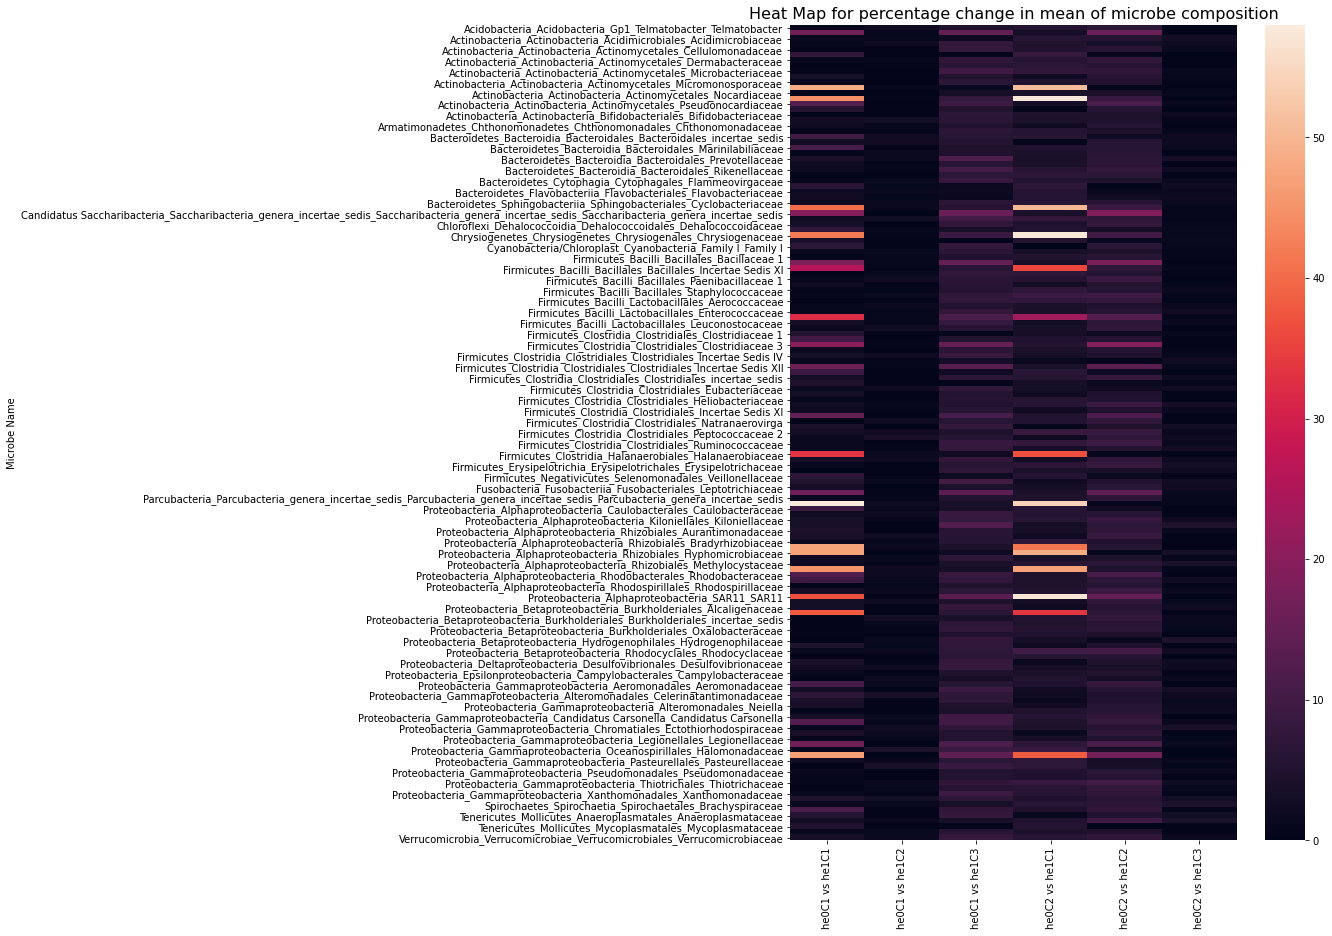

In [ ]:
#DataFrames with mean values of samples for HE0 and HE1
df_cluster_mean_microbes_he0 = pd.DataFrame({'C1': np.mean(df_ra_he0_c1, axis=0).values,
                                             'C2': np.mean(df_ra_he0_c2, axis=0).values},
                                            index = df_ra_he0_c1.columns)

df_cluster_mean_microbes_he1 = pd.DataFrame({'C1': np.mean(df_ra_he1_c1, axis=0).values,
                                             'C2': np.mean(df_ra_he1_c2, axis=0).values,
                                             'C3': np.mean(df_ra_he1_c3, axis=0).values},
                                            index = df_ra_he0_c1.columns)

#DataFrame with percentage difference of microbes abundance for all combinations of clusters in HE0 and HE1
df_microbe_he0_vs_he1 = pd.DataFrame()
for col_he0 in df_cluster_mean_microbes_he0:
  for col_he1 in df_cluster_mean_microbes_he1:
    percent_change = abs((df_cluster_mean_microbes_he0[col_he0] - df_cluster_mean_microbes_he1[col_he1])*100/df_cluster_mean_microbes_he0[col_he0])
    df_microbe_he0_vs_he1[str('he0'+col_he0+' vs he1'+col_he1)] = round(percent_change,2)

#Plotting a heatmap of percentage differences
plt.figure(figsize=(10,15))
plot_ra_he0_he1 = hmap(df_microbe_he0_vs_he1);
figure = plot_ra_he0_he1.get_figure()
plt.title("Heat Map for percentage change in mean of microbe composition", fontsize=16);

As observed from the above heatmap, the C1 cluster of HE1 population shows maximum altered abundance levels compared to other two clusters of HE1.


### b. Identify Most Similar HE0 Clusters to Affected HE1 Clusters

Based on the counts of microbes with significant difference above 30%, 40%, and 50%, the cluster with the lower counts will be selected as similar cluster to most altered cluster (4.1.a)

In [ ]:
#Finding the number of microbes with percentage difference(relative adundance) above 50%
df_microbe_he0_vs_he1[df_microbe_he0_vs_he1.loc[:,:]>50].count()

he0C1 vs he1C1    1
he0C1 vs he1C2    0
he0C1 vs he1C3    0
he0C2 vs he1C1    6
he0C2 vs he1C2    0
he0C2 vs he1C3    0
dtype: int64

When the count of altered microbes using the percentage differences of above 30% and above 40% between HE0C1 vs HE1C1 and HE0C2 vs HE1C1 were compared, we observed that both the groups contained the same number of altertered microbes. But we did see that the percentage differences of above 50% between HE0C1 vs HE1 C1 and HE0 C2 vs HE1 C1 varied significantly i.e. HE0C1 vs HE1C1=1 and HE0C2 vs HE1C1=6, therefore we can conclude that HE1C1 is most similar to HE0C1.

### c. Identify Microbes with Significantly Altered Relative Abundance

In [ ]:
#KS test to find the microbes with significantly altered abundance using alpha level=0.0000025
from scipy.stats import ks_2samp
p_values=[]
for i in df_ra_he1_c1.columns:
  p_values.append(ks_2samp(df_ra_he1_c1[i], df_ra_he0_c1[i]).pvalue)
df_pval = pd.DataFrame({'he0C1 vs he1C1': [0 if p > 0.0000025 else 1 for p in p_values],},
                       index = df_ra_he0_c1.columns)
#List of microbes with significantly altered abundance
Microbes_list

['Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3',
 'Actinobacteria_Actinobacteria_Actinomycetales_Corynebacteriaceae',
 'Actinobacteria_Actinobacteria_Actinomycetales_Nakamurellaceae',
 'Actinobacteria_Actinobacteria_Actinomycetales_Propionibacteriaceae',
 'Actinobacteria_Actinobacteria_Actinomycetales_Pseudonocardiaceae',
 'Bacteroidetes_Bacteroidia_Bacteroidales_Bacteroidales_incertae_sedis',
 'Bacteroidetes_Bacteroidia_Bacteroidales_Marinilabiliaceae',
 'Bacteroidetes_Sphingobacteriia_Sphingobacteriales_Sphingobacteriaceae',
 'Candidatus Saccharibacteria_Saccharibacteria_genera_incertae_sedis_Saccharibacteria_genera_incertae_sedis_Saccharibacteria_genera_incertae_sedis',
 'Chloroflexi_Ktedonobacteria_Ktedonobacterales_Thermosporotrichaceae',
 'Chrysiogenetes_Chrysiogenetes_Chrysiogenales_Chrysiogenaceae',
 'Firmicutes_Bacilli_Bacillales_Bacillaceae 2',
 'Firmicutes_Bacilli_Bacillales_Bacillales_Incertae Sedis XI',
 'Firmicutes_Bacilli_Lactobacillales_Lactobacillaceae',
 'Firmicutes_Clostr

## 2. Identify How Abundance Changes

### a. Microbes which increase and decrease

In [ ]:
#DataFrame of abundance change of microbes with significantly altered abundance in HE1C1 and HE0C1
Change_dataframe=pd.DataFrame()
for Microbe in Microbes_list:
    change = (df_cluster_mean_microbes_he1.get_value(Microbe,'C1') - df_cluster_mean_microbes_he0.get_value(Microbe,'C1'))
    Change_dataframe[str(Microbe)] = [change]
Change_dataframe=Change_dataframe.T

In [ ]:
#Number of microbes with increase in the abundance
Increase=list(Change_dataframe[Change_dataframe.loc[:,0]>0].index)
len(Increase)

10

In [ ]:
#List of microbes with increase in the abundance
Increase

['Actinobacteria_Actinobacteria_Actinomycetales_Nakamurellaceae',
 'Actinobacteria_Actinobacteria_Actinomycetales_Propionibacteriaceae',
 'Bacteroidetes_Sphingobacteriia_Sphingobacteriales_Sphingobacteriaceae',
 'Chrysiogenetes_Chrysiogenetes_Chrysiogenales_Chrysiogenaceae',
 'Firmicutes_Bacilli_Bacillales_Bacillales_Incertae Sedis XI',
 'Firmicutes_Clostridia_Halanaerobiales_Halanaerobiaceae',
 'Parvarchaeota_Candidatus Parvarchaeum_Candidatus Parvarchaeum_Candidatus Parvarchaeum',
 'Proteobacteria_Alphaproteobacteria_Rhizobiales_Brucellaceae',
 'Proteobacteria_Alphaproteobacteria_Rhizobiales_Hyphomicrobiaceae',
 'Proteobacteria_Alphaproteobacteria_SAR11_SAR11']

In [ ]:
#Number of microbes with decrease in the abundance
Decrease=list(Change_dataframe[Change_dataframe.loc[:,0]<0].index)
len(Decrease)

26

In [ ]:
#List of microbes with decrease in the abundance
Decrease

['Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3',
 'Actinobacteria_Actinobacteria_Actinomycetales_Corynebacteriaceae',
 'Actinobacteria_Actinobacteria_Actinomycetales_Pseudonocardiaceae',
 'Bacteroidetes_Bacteroidia_Bacteroidales_Bacteroidales_incertae_sedis',
 'Bacteroidetes_Bacteroidia_Bacteroidales_Marinilabiliaceae',
 'Candidatus Saccharibacteria_Saccharibacteria_genera_incertae_sedis_Saccharibacteria_genera_incertae_sedis_Saccharibacteria_genera_incertae_sedis',
 'Chloroflexi_Ktedonobacteria_Ktedonobacterales_Thermosporotrichaceae',
 'Firmicutes_Bacilli_Bacillales_Bacillaceae 2',
 'Firmicutes_Bacilli_Lactobacillales_Lactobacillaceae',
 'Firmicutes_Clostridia_Clostridiales_Clostridiaceae 2',
 'Firmicutes_Clostridia_Clostridiales_Clostridiaceae 3',
 'Firmicutes_Clostridia_Clostridiales_Clostridiales_Incertae Sedis XII',
 'Firmicutes_Clostridia_Clostridiales_Clostridiales_Incertae Sedis XIII',
 'Firmicutes_Clostridia_Clostridiales_Lachnospiraceae',
 'Firmicutes_Negativicutes_Selenomonadale

We observed that out of 36 microbes that were identified as signicicantly changing , 10 microbes show an increase of relative abundance and 26 microbes show a decrease.

### b. Biological Relations

In [ ]:
#Determining the number of Phylums(groups of microbes with significantly altered abundance)
Taxonomy = []
Phylum = []
for microbes in Microbes_list:
  Phylum.append(microbes.split('_')[0])
  Taxonomy.append('_'.join(microbes.split('_')[1:]))
Organism = []
for p in Phylum:
  if p == 'Parvarchaeota':
    Organism.append('Archaea')
  else:
    Organism.append('Bacteria')
set(Phylum)

{'Acidobacteria',
 'Actinobacteria',
 'Bacteroidetes',
 'Candidatus Saccharibacteria',
 'Chloroflexi',
 'Chrysiogenetes',
 'Firmicutes',
 'Lentisphaerae',
 'Parvarchaeota',
 'Proteobacteria',
 'Synergistetes'}

There are 11 phylums in all the significantly altered microbes in which all except Parvarchaeota are Bacteria, Parvarchaeota is Archaea. 

In [ ]:
#DataFrame of Taxonomy containing the Cellular Organism,Phylum of microbes with significantly altered abundance 
df_Taxonomy = pd.DataFrame({'Cellular Organism':Organism,
                            'Phylum':Phylum,
                            'Name':Taxonomy})

df_Taxonomy.set_index(['Cellular Organism', 'Phylum'])

Name
Cellular Organism Phylum                                                                        
Bacteria          Acidobacteria                                        Acidobacteria_Gp3_Gp3_Gp3
                  Actinobacteria               Actinobacteria_Actinomycetales_Corynebacteriaceae
                  Actinobacteria                  Actinobacteria_Actinomycetales_Nakamurellaceae
                  Actinobacteria               Actinobacteria_Actinomycetales_Propionibacteri...
                  Actinobacteria               Actinobacteria_Actinomycetales_Pseudonocardiaceae
                  Bacteroidetes                Bacteroidia_Bacteroidales_Bacteroidales_incert...
                  Bacteroidetes                      Bacteroidia_Bacteroidales_Marinilabiliaceae
                  Bacteroidetes                Sphingobacteriia_Sphingobacteriales_Sphingobac...
                  Candidatus Saccharibacteria  Saccharibacteria_genera_incertae_sedis_Sacchar...
                  Chloroflexi                  Ktedonobacteria_Ktedonobacterales_Thermosporot...
                  Chrysiogenetes                   Chrysiogenetes_Chrysiogenales_Chrysiogenaceae
                  Firmicutes                                    Bacilli_Bacillales_Bacillaceae 2
                  Firmicutes                     Bacilli_Bacillales_Bacillales_Incertae Sedis XI
                  Firmicutes                            Bacilli_Lactobacillales_Lactobacillaceae
                  Firmicutes                           Clostridia_Clostridiales_Clostridiaceae 2
                  Firmicutes                           Clostridia_Clostridiales_Clostridiaceae 3
                  Firmicutes                   Clostridia_Clostridiales_Clostridiales_Incerta...
                  Firmicutes                   Clostridia_Clostridiales_Clostridiales_Incerta...
                  Firmicutes                            Clostridia_Clostridiales_Lachnospiraceae
                  Firmicutes                         Clostridia_Halanaerobiales_Halanaerobiaceae
                  Firmicutes                       Negativicutes_Selenomonadales_Veillonellaceae
                  Lentisphaerae                       Lentisphaeria_Victivallales_Victivallaceae
Archaea           Parvarchaeota                Candidatus Parvarchaeum_Candidatus Parvarchaeu...
Bacteria          Proteobacteria               Alphaproteobacteria_Caulobacterales_Caulobacte...
                  Proteobacteria                    Alphaproteobacteria_Rhizobiales_Brucellaceae
                  Proteobacteria               Alphaproteobacteria_Rhizobiales_Hyphomicrobiaceae
                  Proteobacteria                    Alphaproteobacteria_Rhizobiales_Rhizobiaceae
                  Proteobacteria               Alphaproteobacteria_Rhodobacterales_Rhodobacte...
                  Proteobacteria               Alphaproteobacteria_Rhodospirillales_Acetobact...
                  Proteobacteria                                 Alphaproteobacteria_SAR11_SAR11
                  Proteobacteria               Betaproteobacteria_Burkholderiales_Burkholderi...
                  Proteobacteria                Gammaproteobacteria_Aeromonadales_Aeromonadaceae
                  Proteobacteria                  Gammaproteobacteria_Chromatiales_Chromatiaceae
                  Proteobacteria               Gammaproteobacteria_Methylococcales_Methylococ...
                  Proteobacteria                            Gammaproteobacteria_Orbales_Orbaceae
                  Synergistetes                         Synergistia_Synergistales_Synergistaceae